In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [2]:
# from poc_data import PocDataset

# poc_raw_dataset = PocDataset(num_cases=2**10)
# data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
# batch, event, time_to_event, _latent_variable = next(iter(data_loader))

# print(batch.shape)
# print(event.shape)
# print(time_to_event.shape)
# print(_latent_variable.shape)

### Data Exploration

In [3]:
#Take a look at the longitudional data

# plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
# plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
# plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
# plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
# plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

# print(event[:5])
# print(time_to_event[:5])
# print(_latent_variable[:5])

# 2. Hyperparameters

In [4]:
DEVICE = 'cuda'

# 3. Defining The Model

# 4. Training the model

tensor([[ 0.0000e+00,  1.2208e+01, -2.1667e-01],
        [ 0.0000e+00,  1.3035e+01,  2.7901e-01],
        [ 0.0000e+00,  1.3862e+01,  5.9460e-01],
        [ 0.0000e+00,  1.4688e+01,  5.2642e-01],
        [ 0.0000e+00,  1.5515e+01,  1.1846e-01],
        [ 0.0000e+00,  1.6342e+01, -3.6595e-01],
        [ 0.0000e+00,  1.7169e+01, -6.1417e-01],
        [ 0.0000e+00,  1.7995e+01, -4.6598e-01],
        [ 0.0000e+00,  1.8822e+01, -1.7027e-02],
        [ 0.0000e+00,  1.9649e+01,  4.4291e-01]], device='cuda:0')
event=1, time_to_event=12, latent_variable=0.617918


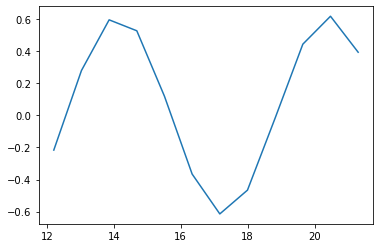

In [5]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

In [6]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork
from losses import loss_1

#poc_raw_dataset = PocDataset(num_cases=2**5)
data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)

NUM_EPOCHS = 1000

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_REGRESS = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1
LOSS_4_AMPLIFIER = 0

input_size = 3
output_size = input_size
MAX_LENGTH = 20
NUM_CAUSES = 2
hidden_size_encoder = 128
hidden_size_regress = 128
fc_size_encoder = 256

# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, output_size, MAX_LENGTH).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
mse_loss = MSELoss()
writer = SummaryWriter()

In [7]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  optimizer_encoder.zero_grad()
  optimizer_decoder.zero_grad()
  optimizer_causess.zero_grad()

  for i, data in enumerate(data_loader):

    batch, event, time_to_event, _latent_variable = data

    batch = batch.to(DEVICE)
    event = event.to(DEVICE)
    time_to_event = time_to_event.to(DEVICE)
    _latent_variable = _latent_variable.to(DEVICE)

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
    encoder_hidden = encoder.initHidden(device=DEVICE)

    last_measurement_index = int(time_to_event.item())
    last_measurement = batch[0][last_measurement_index]

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        encoder_hidden_vector[ei] = encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    context_vector = decoder(last_measurement, encoder_hidden_vector)
    first_hitting_time = causess(context_vector, last_measurement)

    loss1 = loss_1(first_hitting_time, event, time_to_event, MAX_LENGTH)
    loss3 = mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])

    epoch_loss += LOSS_1_AMPLIFIER*loss1 + LOSS_3_AMPLIFIER*loss3

  writer.add_scalar('loss1', loss1.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss3', loss3.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss_epoch', epoch_loss.item(), epoch)

  epoch_loss.backward()

  optimizer_encoder.step()
  optimizer_decoder.step()
  optimizer_causess.step()
  
print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

100%|██████████| 350/350 [00:17<00:00, 19.72it/s]

av_epoch_train_loss= 0.03209453821182251


tensor([[ 1.1341e-02,  1.3044e+01,  2.8399e-01],
        [-2.2644e-02,  1.3916e+01,  2.9827e-01],
        [-1.1646e-02,  1.4612e+01,  1.8679e-01],
        [-4.5377e-03,  1.5556e+01,  1.7366e-01],
        [ 3.8944e-03,  1.6340e+01,  1.2553e-01],
        [ 2.0780e-02,  1.7152e+01, -5.1149e-03],
        [ 2.6789e-02,  1.7992e+01, -8.3752e-02],
        [ 2.0537e-02,  1.8660e+01, -6.9005e-02],
        [ 3.7978e-03,  1.9597e+01,  4.5140e-02],
        [-2.3269e-02,  2.1041e+01,  2.7236e-01]], device='cuda:0')
event=1, time_to_event=12, latent_variable=0.617918


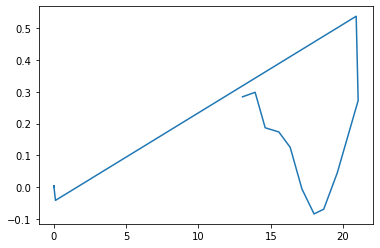

In [8]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
test_encoder_hidden = encoder.initHidden(device=DEVICE)

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_last_measurement = test_batch[0][ei]
test_context_vector = decoder(test_last_measurement, test_encoder_hidden_vector)
test_first_hitting_time = causess(test_context_vector, test_last_measurement)

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector.cpu()[0][0:23,1]), test_encoder_output_vector.cpu()[0][0:23,2])
print(test_encoder_output_vector[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

(0.0, 1.0)

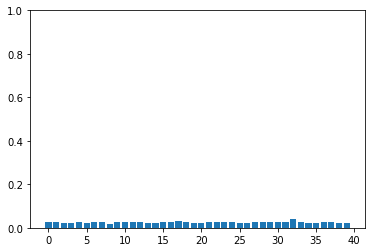

In [9]:
plt.bar([i for i in range(test_first_hitting_time.size(1))], test_first_hitting_time.squeeze().cpu().detach().numpy())
plt.ylim([0,1])

(0.0, 1.0)

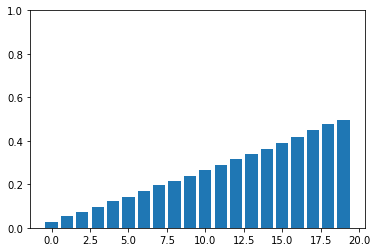

In [10]:
plt.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
plt.ylim([0,1])

(0.0, 1.0)

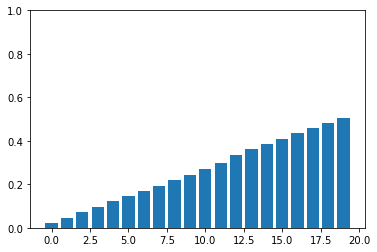

In [11]:
plt.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:], dim=0).cpu().detach().numpy())
plt.ylim([0,1])

# 4. Validating The Model

In [12]:
from poc_data import PocDataset

val_poc_raw_dataset = PocDataset(num_cases=2**5)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=1)
val_batch, val_event, val_time_to_event, val_latent_variable = next(iter(val_data_loader))
val_batch = val_batch.to(DEVICE)

encoder.eval()
decoder.eval()
causess.eval()

CauseSpecificSubnetwork(
  (layer1): Linear(in_features=131, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=40, bias=True)
)

In [13]:
loss1 = 0
loss2 = 0
loss3 = 0
epoch_loss = 0

for i, data in enumerate(val_data_loader):

    batch, event, time_to_event, _latent_variable = data

    batch = batch.to(DEVICE)
    event = event.to(DEVICE)
    time_to_event = time_to_event.to(DEVICE)
    _latent_variable = _latent_variable.to(DEVICE)

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
    encoder_hidden = encoder.initHidden(device=DEVICE)

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        encoder_hidden_vector[ei] = encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    last_measurement = batch[0][ei]
    context_vector = decoder(last_measurement, encoder_hidden_vector)
    first_hitting_time = causess(context_vector, last_measurement)

    loss1 += loss_1(first_hitting_time, event, time_to_event, MAX_LENGTH)
    loss3 += mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])

print("loss1=", loss1.item()/len(val_data_loader))
print("loss2=", loss2/len(val_data_loader))
print("loss3=", loss3.item()/len(val_data_loader))

loss1= 18.673057556152344
loss2= 0.0
loss3= 87.7603759765625


loss1 record = 3.6
loss3 record = 13.9